In [1]:
# Import libraries
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import os
from scipy.signal import spectrogram
import seaborn as sns
import glob

In [2]:
# Load audio file
path = os.path.join(os.getcwd(), "data")
wav_files = glob.glob(os.path.join(path, "*.wav"))
path = os.path.join(os.getcwd(), "data")
file_path = wav_files[0]
y, sr = librosa.load(file_path, sr=None)
print(f"Audio duration: {librosa.get_duration(y=y, sr=sr):.2f} seconds")
print(f"Sample rate: {sr} Hz")

Audio duration: 60.03 seconds
Sample rate: 16000 Hz


In [3]:
# Normalize amplitude
y = y / np.max(np.abs(y))

In [4]:
# Detect non-silent segments
non_silent_intervals = librosa.effects.split(y, top_db=20)
y_trimmed = np.concatenate([y[start:end] for start, end in non_silent_intervals])

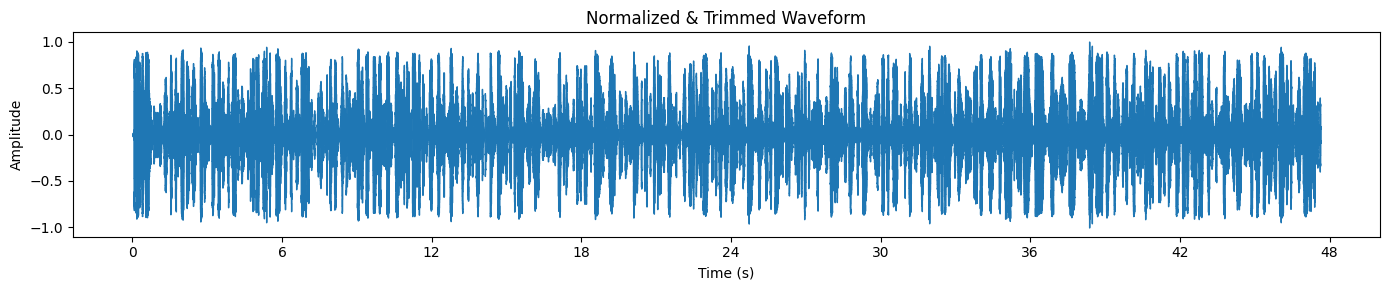

In [5]:
# Plot waveform
plt.figure(figsize=(14, 3))
librosa.display.waveshow(y_trimmed, sr=sr)
plt.title("Normalized & Trimmed Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

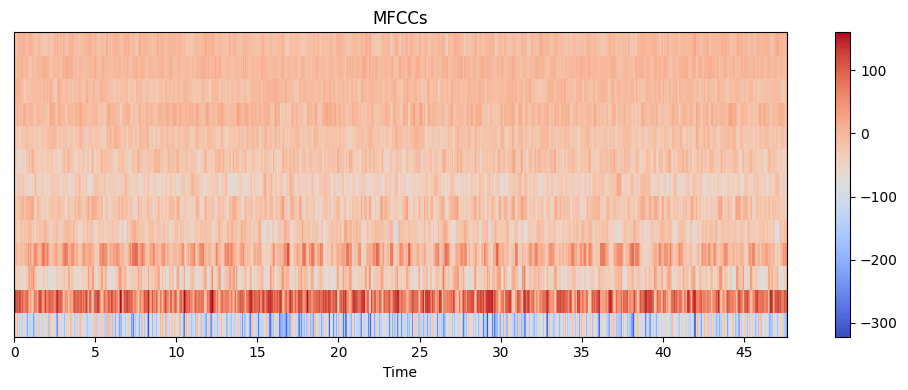

In [6]:
# Extract MFCCs
mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time', sr=sr)
plt.colorbar()
plt.title("MFCCs")
plt.tight_layout()
plt.show()

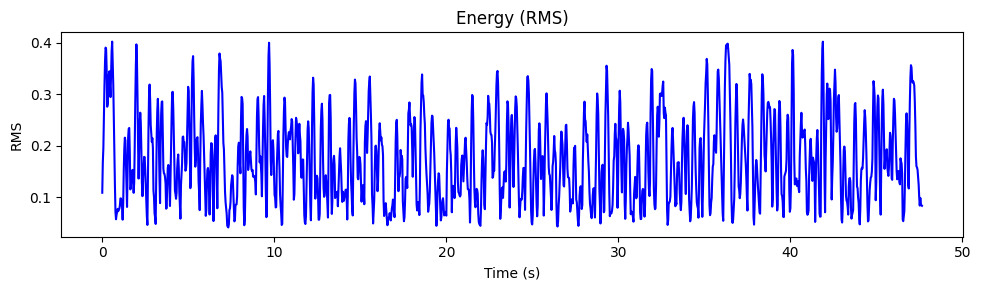

In [7]:
# Extract energy (RMS)
rms = librosa.feature.rms(y=y_trimmed)[0]
frames = range(len(rms))
t = librosa.frames_to_time(frames, sr=sr)
plt.figure(figsize=(10, 3))
plt.plot(t, rms, color='b')
plt.title("Energy (RMS)")
plt.xlabel("Time (s)")
plt.ylabel("RMS")
plt.tight_layout()
plt.show()

In [8]:
# Extract pitch using librosa's piptrack
pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
pitch_track = []

for i in range(pitches.shape[1]):
    index = magnitudes[:, i].argmax()
    pitch = pitches[index, i]
    pitch_track.append(pitch if pitch > 0 else np.nan)

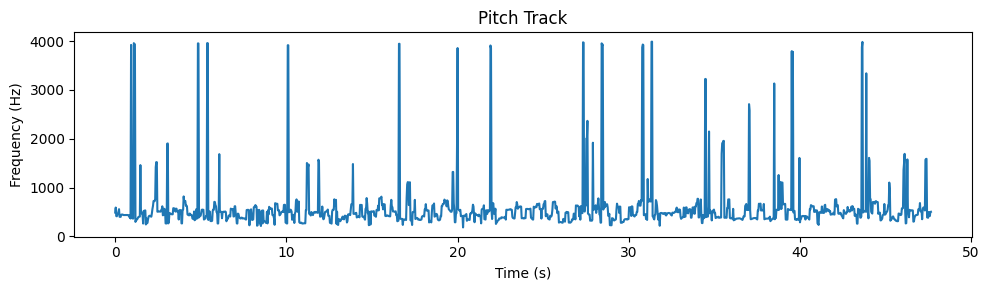

In [9]:
plt.figure(figsize=(10, 3))
plt.plot(librosa.frames_to_time(range(len(pitch_track)), sr=sr), pitch_track)
plt.title("Pitch Track")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

In [10]:
# Extract pitch, energy, silence and speech duration-based prosodic features

# ---- PITCH ANALYSIS ----
# Pitch gives us information about intonation and vocal expressiveness.
# A flat pitch (low std or range) may indicate monotone speech.

pitches, magnitudes = librosa.piptrack(y=y_trimmed, sr=sr)
pitch_values = pitches[magnitudes > np.median(magnitudes)]  # filter out low-energy frames

pitch_mean = np.mean(pitch_values) if len(pitch_values) > 0 else 0
pitch_std = np.std(pitch_values) if len(pitch_values) > 0 else 0
pitch_range = np.max(pitch_values) - np.min(pitch_values) if len(pitch_values) > 0 else 0

print(f"Pitch mean: {pitch_mean:.2f} Hz")         # Average pitch (intonation center)
print(f"Pitch std: {pitch_std:.2f} Hz")           # Variation in pitch — higher std = more expressive
print(f"Pitch range: {pitch_range:.2f} Hz")       # Overall pitch span — tells us vocal dynamism

# ---- ENERGY ANALYSIS ----
# Energy relates to perceived loudness and speech emphasis.
# Variation in energy (std) reflects dynamics and prosodic emphasis.

energy = librosa.feature.rms(y=y_trimmed)[0]

energy_mean = np.mean(energy)
energy_std = np.std(energy)

print(f"Energy mean: {energy_mean:.4f}")          # Average loudness
print(f"Energy std: {energy_std:.4f}")            # Variation in loudness — flat = dull, varied = dynamic

# ---- PAUSE / SILENCE ANALYSIS ----
# We detect pauses by identifying non-silent intervals.
# This tells us about speech rhythm, hesitation, and fluency.

non_silent_intervals = librosa.effects.split(y, top_db=20)  # segments considered "speech"

durations = [(end - start) / sr for start, end in non_silent_intervals]
total_speech_duration = sum(durations)                      # actual voiced segments
total_duration = librosa.get_duration(y=y, sr=sr)
silence_duration = total_duration - total_speech_duration
pause_count = len(non_silent_intervals) - 1                 # number of pauses = speech chunks - 1

print(f"Total audio duration: {total_duration:.2f} s")      # Full duration
print(f"Spoken duration: {total_speech_duration:.2f} s")    # Time actually speaking
print(f"Silence duration: {silence_duration:.2f} s")        # Total silence between phrases
print(f"Number of pauses: {pause_count}")                   # Count of pauses
print(f"% Silence: {(silence_duration / total_duration) * 100:.2f}%")  # Silence ratio

# This will tell us if the speaker is fluent (few pauses), hesitant (many pauses),
# and whether they speak fast (short pauses, short overall duration) or slow.


Pitch mean: 1410.50 Hz
Pitch std: 1013.66 Hz
Pitch range: 3843.52 Hz
Energy mean: 0.1747
Energy std: 0.0827
Total audio duration: 60.03 s
Spoken duration: 47.65 s
Silence duration: 12.38 s
Number of pauses: 38
% Silence: 20.63%


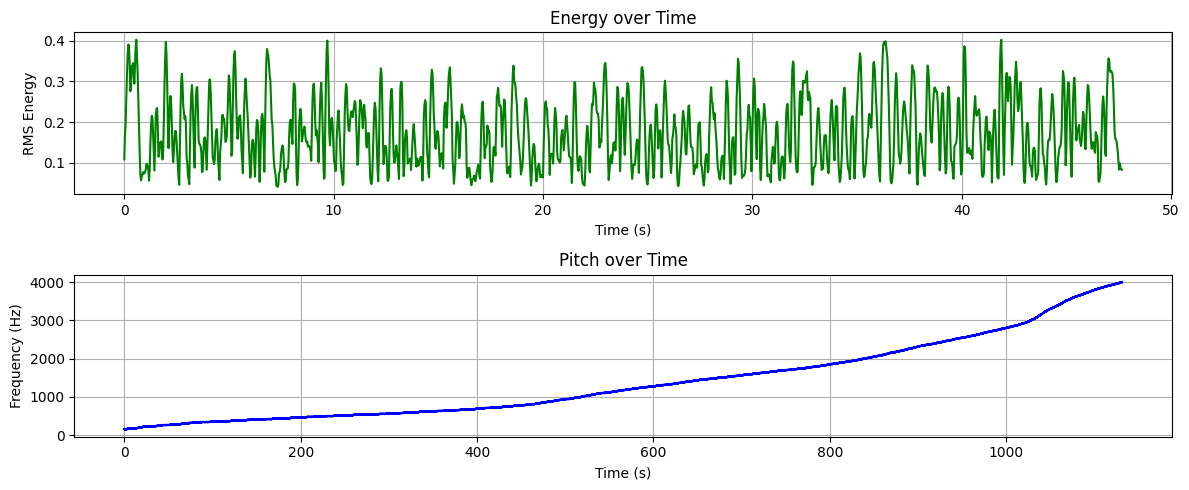

In [11]:
# Plot both energy and pitch over time to observe prosodic patterns visually

plt.figure(figsize=(12, 5))

# Energy over time
plt.subplot(2, 1, 1)
frames = range(len(energy))
t = librosa.frames_to_time(frames, sr=sr)
plt.plot(t, energy, label="Energy", color="green")
plt.title("Energy over Time")
plt.ylabel("RMS Energy")
plt.xlabel("Time (s)")
plt.grid(True)

# Pitch over time
plt.subplot(2, 1, 2)
times = librosa.frames_to_time(range(len(pitch_values)), sr=sr)
plt.plot(times, pitch_values, label="Pitch", color="blue")
plt.title("Pitch over Time")
plt.ylabel("Frequency (Hz)")
plt.xlabel("Time (s)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [12]:
# Guardar un fragmento de voz limpio (por ejemplo, el primer intervalo no silencioso)
first_interval = non_silent_intervals[0]
start_sample, end_sample = first_interval
segment = y[start_sample:end_sample]

# Guardar como nuevo archivo
sf.write("voice_cleaned.wav", segment, sr)

In [13]:
info = sf.info("voice_cleaned.wav")
print(info)

voice_cleaned.wav
samplerate: 16000 Hz
channels: 1
duration: 12800 samples
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]


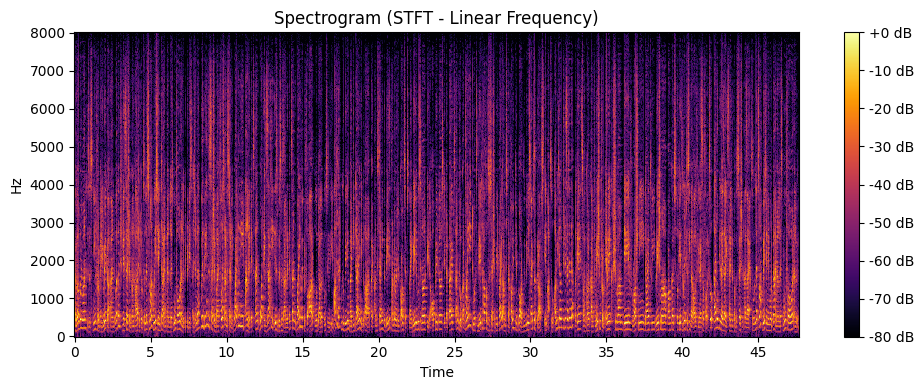

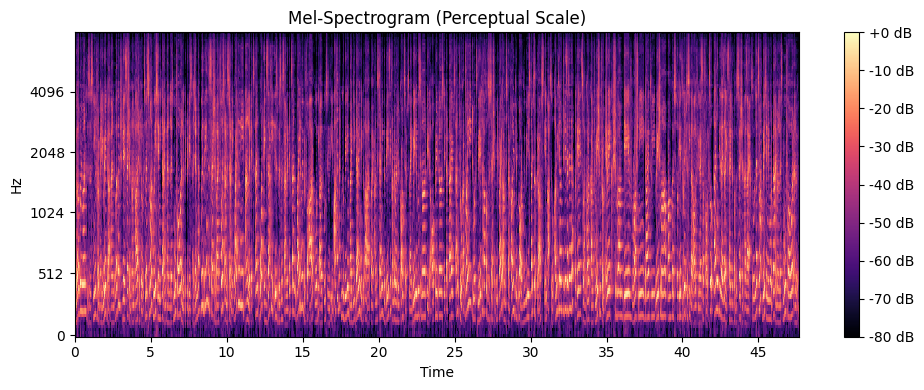

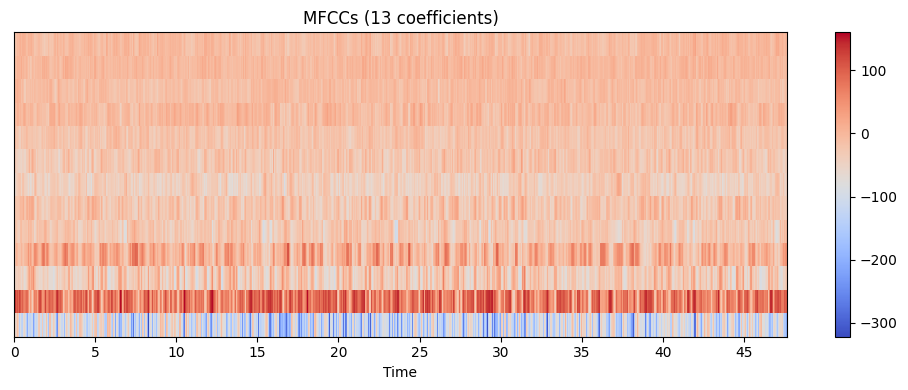

In [14]:
# -----------------------------
# STFT Spectrogram
# -----------------------------
D = np.abs(librosa.stft(y_trimmed, n_fft=1024, hop_length=512))  # magnitude
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(DB, sr=sr, hop_length=512, x_axis='time', y_axis='linear', cmap='inferno')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT - Linear Frequency)')
plt.tight_layout()
plt.show()

# -----------------------------
# Mel-Spectrogram
# -----------------------------
mel_spec = librosa.feature.melspectrogram(y=y_trimmed, sr=sr, n_fft=1024, hop_length=512, n_mels=128)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_db, sr=sr, hop_length=512, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram (Perceptual Scale)')
plt.tight_layout()
plt.show()

# -----------------------------
# MFCCs (Mel Frequency Cepstral Coefficients)
# -----------------------------
mfccs = librosa.feature.mfcc(y=y_trimmed, sr=sr, n_mfcc=13, hop_length=512)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, sr=sr, hop_length=512, x_axis='time')
plt.colorbar()
plt.title('MFCCs (13 coefficients)')
plt.tight_layout()
plt.show()